In [1]:
import cv2
import numpy as np
from skimage.feature import corner_peaks
from scipy import ndimage as ndi

In [2]:
def isvalid(i, j, r, c):
    if i >= r or j >= c or i < 0 or j < 0:
        return 0
    return 1

def convert_to_grayscale(image):
    B = image[:,:,0]
    G = image[:,:,1]
    R = image[:,:,2]
    img_gray = 0.2989*R + 0.5870*G + 0.1140*B
    img_gray = img_gray.astype('uint8')
    return img_gray

def gaussian(m, n, sigma = 1):
    g = np.zeros((m,n))
    m = m // 2
    n = n // 2
    for i in range(-m,m+1):
        for j in range(-n,n+1):
            den = 2.0*np.pi*(sigma**2)
            num = np.exp(-(i**2 + j**2) / (2*(sigma**2)))
            g[i+m][j+n] = num / den
    return g

def filter2D(image, kernel):
    r, c = image.shape
    m, n = kernel.shape
    filtered = np.zeros(image.shape)
    dx, dy = m//2, n//2
    for i in range(r):
        for j in range(c):
            psum = 0.0
            for k in range(i-dx,i+dx+1):
                for l in range(j-dy,j+dy+1):
                    if isvalid(k,l,r,c):
                        psum += image[k][l] * kernel[i-k+dx][j-l+dy]
            filtered[i][j] = psum
    return filtered

def scaling(image, sigmag = 3, k = 5):
    kernel = gaussian(k,k,sigmag)
    scaled = filter2D(image,kernel)
    return scaled

def edge_sobel(image):
    Sx = np.array([
        [-1,0,1],
        [-2,0,2],
        [-1,0,1]
    ])
    Sx = Sx / 8.0
    
    Sy = np.array([
        [-1,-2,-1],
        [0,0,0],
        [1,2,1]
    ])
    Sy = Sy / 8.0
    
    Ix = filter2D(image, Sx)
    Iy = filter2D(image, Sy)
    
    grads = np.sqrt(Ix**2 + Iy**2)
    return Ix, Iy, grads

def otsu(image):

    hist, _ = np.histogram(image, bins=256, range=(0, 255))
    total = image.shape[0]*image.shape[1]
    current_max, threshold = 0, 0
    sumT, sumF, sumB = 0, 0, 0
    
    for i in range(0,256):
        sumT += i * hist[i]
    
    weightB, weightF = 0, 0
    varBetween, meanB, meanF = 0, 0, 0
    
    for i in range(0,256):
        weightB += hist[i]
        weightF = total - weightB
        if weightF == 0:
            break
        sumB += i*hist[i]
        sumF = sumT - sumB
        meanB = sumB/weightB
        meanF = sumF/weightF
        varBetween = weightB * weightF
        varBetween *= (meanB-meanF)*(meanB-meanF)
        if varBetween > current_max:
            current_max = varBetween
            threshold = i  
    
    th = image
    th[th>=threshold]=255
    th[th<threshold]=0
    
    return th

def harris(img):
    
    img_gray = convert_to_grayscale(img)
    blur = scaling(img_gray, 3, 5)
#     blur=cv2.GaussianBlur(img_gray,(3,3),0)
    otsu_thresh = otsu(blur)
    
    Ix, Iy, _ = edge_sobel(blur)
    Ixx = scaling(Ix*Ix, 3, 5)
    Ixy = scaling(Ix*Iy, 3, 5)
    Iyy = scaling(Iy*Iy, 3, 5)
#     Ixx = ndi.gaussian_filter(Ix**2, sigma=1)
#     Ixy = ndi.gaussian_filter(Iy*Ix, sigma=1)
#     Iyy = ndi.gaussian_filter(Iy**2, sigma=1)
    
    detA = Ixx*Iyy - Ixy**2
    traceA = Ixx + Iyy
    Rs = detA - 0.05*traceA**2
#     corners = corner_peaks(R)
    
    img_copy_for_corners = np.copy(img)
#     for corner in corners:
#         x, y = corner[0], corner[1]
#         img_copy_for_corners=cv2.circle(img_copy_for_corners, (x,y), 4, (255,0,0), -1)
    
    threshold=1e-2
    nms_size=10
    # apply thresholding
    Rs = Rs * (Rs > (threshold * Rs.max())) * (Rs > 0)
    # apply non maximal suppression
    rows, columns = np.nonzero(Rs)
    new_Rs = np.zeros(Rs.shape)
    for r,c in zip(rows,columns):
        minr = max(0, r - nms_size / 2)
        maxr = min(img.shape[0], minr + nms_size)
        minc = max(0, c - nms_size / 2)
        maxc = min(img.shape[1], minc + nms_size)
        if Rs[r,c] == Rs[int(minr):int(maxr),int(minc):int(maxc)].max():
            new_Rs[r,c] = Rs[r,c]
   
    corners_x,corners_y = np.nonzero(new_Rs)
    
#     print(corners_x.shape)

#     img_copy_for_corners = np.copy(img)

    for x,y in zip(corners_x, corners_y):
#         x, y = corner[0], corner[1]
        img_copy_for_corners=cv2.circle(img_copy_for_corners, (x,y), 4, (255,0,0), -1)
        
    return img_copy_for_corners

#     cv2.imwrite("finalimage.png", img_copy_for_corners)

In [3]:
img = cv2.imread('./images/checkerboard.jpg')
# img = cv2.imread('./images/checkerboard.jpg')

harr_img = harris(img)

/home/mvp18/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in long_scalars


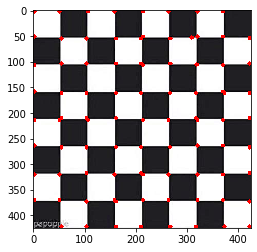

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.uint8(harr_img))
plt.show()

In [ ]:
cv2.imwrite("./images/harris.png", harr_img)

In [ ]:
operatedImage = np.float32(convert_to_grayscale(img)) 
  
# apply the cv2.cornerHarris method 
# to detect the corners with appropriate 
# values as input parameters 
dest = cv2.cornerHarris(operatedImage, 2, 5, 0.07) 
  
# Results are marked through the dilated corners 
dest = cv2.dilate(dest, None) 
  
# Reverting back to the original image, 
# with optimal threshold value 
img[dest > 0.01 * dest.max()]=[0, 0, 255]

In [ ]:
plt.imshow(np.uint8(dest), cmap='gray')
plt.show()